# Imports

In [1]:
# Packages
import random
import pandas as pd
import pickle
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import platform
import os
from tabulate import tabulate


Data taken from: https://www.kaggle.com/datasets/rmisra/news-category-dataset/

# Methods

In [7]:
def train_with_TBBTT(max_epochs, model, dataloader, criterion, optimizer, chunk_size, clip=None, device='cpu',
                     print_every=1):
    losses = []
    loss_hist = []
    running_loss = 0
    perplexity_hist = []
    epoch = 0
    model = model.to(device)
    
    print("\n", "Training model2 with TBTT ...", "\n" )
    while epoch < max_epochs:
        epoch += 1
        model.train()
        # n_chunks=0
        for input_c, output in dataloader:
            # Get the number of chunks
            n_chunks = input_c.shape[1] // chunk_size

            # Loop on chunks
            for j in range(n_chunks):
                # Switch between the chunks
                if j < n_chunks - 1:
                    input_chunk = input_c[:, j * chunk_size:(j + 1) * chunk_size].to(device).to(torch.int64)
                    output_chunk = output[:, j * chunk_size:(j + 1) * chunk_size].to(device).to(torch.int64)
                else:
                    input_chunk = input_c[:, j * chunk_size:].to(device).to(torch.int64)
                    output_chunk = output[:, j * chunk_size:].to(device).to(torch.int64)

                # Initialize model's state and perform forward pass
                # If it is the first chunk, initialize the state to 0
                if j == 0:
                    prev_state = model.init_state(b_size=input_c.shape[0], DEVICE=device)
                    h, c = prev_state
                else:  # Initialize the state to the previous state - detached!
                    h, c = state[0].detach(), state[1].detach()
                h, c = h.to(device), c.to(device)

                # Forward step
                out, state = model(input_chunk, (h, c))
                out = out.to(device)

                # Calculate loss
                loss = criterion(out.transpose(1, 2), output_chunk)
                losses.append(loss.item())
                running_loss += loss.item()

                # Calculate gradients and update parameters
                optimizer.zero_grad()
                loss.backward(retain_graph=True)

                # Clipping if needed
                if clip:
                    nn.utils.clip_grad_norm_(model.parameters(), clip)

                # Update parameters
                optimizer.step()

        if (epoch == 1):
            user_prompt = input("Please enter a sentence: ")
            user_prompt = user_prompt.lower().split(" ")
            print("user propmpt: ", user_prompt)
        if print_every and (epoch % print_every) == 0:
            print("Epoch: {}/{}, Loss: {:8.4f}".format(int(epoch), int(max_epochs), running_loss / (
                float(len(dataloader) * n_chunks))))  # *print_every
            perplexity = torch.exp(torch.tensor(running_loss / float(print_every * len(dataloader) * n_chunks)))
            print("Perplexity: ", perplexity.item())  # ??
            loss_hist.append(running_loss / (float(len(dataloader) * n_chunks * print_every)))
            perplexity_hist.append(perplexity)
            running_loss = 0
            seed = keys_to_values(user_prompt, word_to_int, None)  # [1:-1] #["the", "government"]
            print("seed: ", seed)
            print(seed, "[SOFTMAX]", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[1], int_to_word,
                               "<?>")))
            print(seed, "[ARGMAX]", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[0], int_to_word,
                               "<?>")))
        if (epoch == max_epochs):
            print(seed, "[SOFTMAX] 1", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[1], int_to_word,
                               "<?>")))
            print(seed, "[ARGMAX] 1", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[0], int_to_word,
                               "<?>")))
            print(seed, "[SOFTMAX] 2", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[1], int_to_word,
                               "<?>")))
            print(seed, "[ARGMAX] 2", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[0], int_to_word,
                               "<?>")))
            print(seed, "[SOFTMAX] 3", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[1], int_to_word,
                               "<?>")))
            print(seed, "[ARGMAX] 3", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[0], int_to_word,
                               "<?>")))

    return model, loss_hist, perplexity_hist


# ________________________________FILE_SYSTEM___________________________________

def exists(directory_path, file_name):
    file_path = os.path.join(directory_path, file_name)

    # Check if the file exists
    if os.path.exists(file_path):
        # Check if the file is not empty
        if os.path.getsize(file_path) > 0:
            # Assuming it's a pickle file, you can add additional checks if needed
            if ((file_name.endswith('.pkl')) or (file_name.endswith('.pickle'))):
                return True
            else:
                print(f"The file '{file_name}' is not a pickle file.")
        else:
            print(f"The file '{file_name}' is empty.")
    else:
        print(f"The file '{file_name}' does not exist in the specified directory.")

    return False


# ________________________________PLOTS___________________________________

def plot_loss(loss, steps, toprint=True, label='', title='Plot of Loss Function', ylabel='loss at given step'):
    if (toprint == True):
        plt.plot(steps, loss, label=label)
        plt.xlabel('steps')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        return plt.plot(steps, loss, label=label)


# ________________________________DATA.4__________________________________

def keys_to_values(keys, word_to_int, default_if_missing=None):
    return [word_to_int.get(key, default_if_missing) for key in keys]


class CustomDataset(Dataset):
    def __init__(self, token_sequences, word_to_int, transform=None):
        self.item_list = []

        for sequence in token_sequences:
            index = keys_to_values(sequence, word_to_int, None)
            element = index[1:]
            index = index[:-1]
            data_point = [index, element]
            self.item_list.append(data_point)

    def __len__(self):
        return len(self.item_list)

    def __getitem__(self, idx):
        sample = self.item_list
        x, y = sample[idx][0], sample[idx][1]

        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)


# _____________________________DATA.5____________________________________
def collate_fn(batch, pad_value):
    data, targets = zip(*batch)  # batch is split in batch of data and atch of targets batch[0], batch[1] #
    # print("batch 64: ", batch, "\n\n zip(*batch) | DATA: ", data," |TARGETS:", targets)
    padded_data = nn.utils.rnn.pad_sequence(data, batch_first=True,
                                            padding_value=pad_value)
    padded_targets = nn.utils.rnn.pad_sequence(targets, batch_first=True,
                                               padding_value=pad_value)
    # print("batched data: ", padded_data, "\n batched targets: ", padded_targets.size)
    return padded_data, padded_targets


# both the tensors are padded with the padding corresponding to the maximal value of the lenght of the data

# ___________________________MODEL.1______________________________________
class Model(nn.Module):
    def __init__(self, word_to_int, hidden_size, emb_dim=8, n_layers=1, dropout_p=0.2):
        # word_to_int, 1024, 150, n_layers=2, dropout_p=0.2
        super(Model, self).__init__()

        self.vocab_size = len(word_to_int)
        self.hidden_size = hidden_size
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.dropout_p = dropout_p

        # dimensions: batches x seq_length x emb_dim
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.emb_dim,
            padding_idx=word_to_int["PAD"])

        # self.lstm = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hidden_size,
        #                     num_layers=self.n_layers, bias=True,
        #                     batch_first=False, bidirectional=False)

        self.lstm = nn.LSTM(input_size=self.emb_dim,
                            hidden_size=self.hidden_size,
                            num_layers=self.n_layers,
                            batch_first=True)

        self.dropout = nn.Dropout(self.dropout_p)

        self.fc = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.vocab_size)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        yhat, state = self.lstm(embed,
                                prev_state)  # yhat is the full sequence prediction, while state is the last hidden state (coincides with yhat[-1] if n_layers=1)

        # yhat, state = self.lstm(embed, prev_state)
        yhat = self.dropout(yhat)
        out = self.fc(yhat)
        return out, state

    def init_state(self, b_size=1, DEVICE="cpu"):  # there was no seq_lenght initially
        # return torch.zeros(self.n_layers, b_size, self.hidden_size)
        x = torch.zeros(self.n_layers, b_size, self.hidden_size).to(DEVICE)
        y = torch.zeros(self.n_layers, b_size, self.hidden_size).to(DEVICE)
        return x, y


#     (
#         torch.zeros(self.n_layers, b_size, self.hidden_size).to(DEVICE),
#         torch.zeros(self.n_layers, b_size, self.hidden_size).to(DEVICE)
#     )

# _____________________________EVALUATION1.1______________________________

def sample_next(model, x, prev_state, topk=5, uniform=True):
    out, state = model(x, prev_state)

    last_out = out[0, -1, :]

    topk = topk if topk else last_out.shape[0]
    top_logit, top_ix = torch.topk(last_out, k=topk, dim=-1)
    # top_logit = top_logit.to(DEVICE)
    # top_ix = top_ix.to(DEVICE)

    # Get the softmax of the topk's and sample
    p = None if uniform else F.softmax(top_logit.detach().cpu(), dim=-1).numpy()
    sampled_ix = np.random.choice(top_ix.cpu().numpy(), p=p)
    # sampled_ix = sampled_ix.to(DEVICE)

    return sampled_ix, state


def sample_argmax(model, x, prev_state):
    out, state = model(x, prev_state)
    last_out = out[0, -1, :]

    argmax_ix = torch.argmax(last_out, dim=-1).item()
    print("argmax:", argmax_ix)

    return argmax_ix, state


def sample(model, seed, topk=5, uniform=True, max_seqlen=18, stop_on=None, DEVICE='cpu'):
    seed = seed if isinstance(seed, (list, tuple)) else [seed]

    # model = model.to(DEVICE)

    model.eval()
    with torch.no_grad():
        sampled_arg_list = seed[:]
        sampled_soft_list = seed[:]
        # sampled_ix_list =  sampled_ix_list.to(DEVICE)

        x_arg = torch.tensor([seed])
        x_soft = torch.tensor([seed])
        x_arg = x_arg.to(DEVICE)
        x_soft = x_soft.to(DEVICE)

        prev_state = model.init_state(b_size=1, DEVICE=DEVICE)

        # loop for softmax
        for t in range(max_seqlen - len(seed)):
            # sampled_arg, prev_state = sample_argmax(model, x_arg, prev_state)#sample_next(model, x, prev_state, topk, uniform)
            sampled_soft, prev_state = sample_next(model, x_soft, prev_state, topk, uniform)
            sampled_soft_list.append(sampled_soft)
            # sampled_arg_list.append(sampled_arg)
            # x_arg = torch.tensor([[sampled_arg]])
            # x_arg = x_arg.to(DEVICE)
            x_soft = torch.tensor([[sampled_soft]])
            x_soft = x_soft.to(DEVICE)
            if (sampled_soft == stop_on):
                break

        # loop for argmax
        for t in range(max_seqlen - len(seed)):
            sampled_arg, prev_state = sample_argmax(model, x_arg,
                                                    prev_state)  # sample_next(model, x, prev_state, topk, uniform)
            # sampled_soft, prev_state = sample_next(model, x_soft, prev_state, topk, uniform)
            # sampled_soft_list.append(sampled_soft)
            sampled_arg_list.append(sampled_arg)
            x_arg = torch.tensor([[sampled_arg]])
            x_arg = x_arg.to(DEVICE)
            # x_soft = torch.tensor([[sampled_arg]])
            # x_soft = x_soft.to(DEVICE)

            if (sampled_arg == stop_on):
                break

    model.train()
    return sampled_arg_list, sampled_soft_list


# _____________________________TRAINING.1______________________________
def train(model, data, num_epochs, criterion, lr=0.001, print_every=50, clip=None, DEVICE='cpu'):
    # Here I setup the DEVICE
    # DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print("=========== USING ", DEVICE, "=================\n")
    model = model.to(DEVICE)
    model.train()

    # costs = []
    running_loss = 0
    loss_hist = []
    perplexity_hist = []

    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    print("\n", "Training model1 ...", "\n" )
    epoch = 0
    while epoch < num_epochs:
        epoch += 1
        for x, y in data:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            optimizer.zero_grad()

            prev_state = model.init_state(b_size=x.shape[0], DEVICE=DEVICE)
            # prev_state = [prev_state[0].to(DEVICE), prev_state[1].to(DEVICE)]
            out, state = model(x, prev_state)  # out has dim: batch x seq_length x vocab_size
            out = out.to(DEVICE)

            # print(f"Input shape: {x.shape}, Target shape: {y.shape}, Output shape: {out.shape}")

            # Calculate loss
            loss = criterion(out.transpose(1, 2), y)  # transpose is required to obtain batch x vocab_size x seq_length
            # costs.append(loss.item())
            running_loss += loss.item()

            # Calculate gradients and update parameters
            loss.backward()
            if clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        if (epoch == 1):
            user_prompt = input("Please enter a sentence: ")
            user_prompt = user_prompt.lower().split(" ")
            print("user propmpt: ", user_prompt)
        if print_every and (epoch % print_every) == 0:
            print("Epoch: {}/{}, Loss: {:8.4f}".format(int(epoch), int(num_epochs),
                                                       running_loss / float(print_every * len(data))))
            perplexity = torch.exp(torch.tensor(running_loss / float(print_every * len(data))))
            print("Perplexity: ", perplexity.item())  # ??
            loss_hist.append(running_loss / float(print_every * len(data)))
            perplexity_hist.append(perplexity)
            running_loss = 0
            seed = keys_to_values(user_prompt, word_to_int, None)  # [1:-1] #["the", "government"]
            print("seed: ", seed)
            print(seed, "[SOFTMAX]", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[1], int_to_word,
                               "<?>")))
            print(seed, "[ARGMAX]", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[0], int_to_word,
                               "<?>")))
        if (epoch == num_epochs):
            print(seed, "[SOFTMAX] 1", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[1], int_to_word,
                               "<?>")))
            print(seed, "[ARGMAX] 1", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[0], int_to_word,
                               "<?>")))
            print(seed, "[SOFTMAX] 2", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[1], int_to_word,
                               "<?>")))
            print(seed, "[ARGMAX] 2", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[0], int_to_word,
                               "<?>")))
            print(seed, "[SOFTMAX] 3", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[1], int_to_word,
                               "<?>")))
            print(seed, "[ARGMAX] 3", "=>", " ".join(
                keys_to_values(sample(model, seed, 5, False, 30, word_to_int["<EOS>"], DEVICE=DEVICE)[0], int_to_word,
                               "<?>")))

    return model, loss_hist, perplexity_hist  

# Main

<div style="background-color: #fff3cd; padding: 10px; border-left: 5px solid #ffecb5; border-radius: 5px;">
  <strong>⚠️ Warning!</strong>  
  This model may generate offensive content. Please proceed with caution.
</div>


<div style="background-color: #f9f9f9; padding: 15px; border-left: 6px solid #4CAF50; border-radius: 5px;">
  
  <h3>🚀 How to Run the Model Training</h3>
  
  As you can notice, all the paths are intended to work within **Kaggle**:
  
  * The dataset is stored in:  
    <code>/kaggle/input/</code>
  
  * The outputs (and working files) are stored in:  
    <code>/kaggle/working/</code>
  
  Feel free to modify these paths as needed for your own environment.

  **Note:* If you want to speed up the process, upload the following files to the working folder (in this case, <code>/kaggle/working</code>, but you can use any folder):
  
      * <code>word_to_int.pickle</code>
      * <code>int_to_word.pickle</code>
      * <code>news_tokens.pickle</code>
  
     Uploading these files will allow you to bypass all the data preprocessing steps, saving time.
  
<hr/>
  
<h3>🧠 About the Model</h3>

This is an **LSTM** model designed to generate news headlines based on an input prompt. For example, if you input <i>"Trump Wants"</i>, the model will attempt to continue the sentence. 

We train **two models** and run **two training sessions**:

1. **Basic Training**  
2. **Training with Truncated Backpropagation Through Time (TBTT)**

    <div style="background-color: #f8d7da; padding: 10px; border-left: 6px solid #dc3545; border-radius: 5px; margin-top: 15px;">
        <strong>❗ Important:</strong>  
            During the first iteration of each training session, you'll be asked to provide the initial prompt for the headline.  
            <br> It's best to use a few <strong>common words</strong>, as some words may not exist in the model's vocabulary.
    </div>

</div>


The file 'word_to_int.pickle' does not exist in the specified directory.

 -------------Example of Headline and Tokenized Headline-----------------
Headline: Patrick Lyoya’s Death Casts A Light On How Police Mishandle Traffic Stops
Tokens: ['patrick', 'lyoya’s', 'death', 'casts', 'a', 'light', 'on', 'how', 'police', 'mishandle', 'traffic', 'stops', '<EOS>']
------------------------------------------------------------------------
Number of tokenized titles: 35602 

Number of unique words: 33207 

word_to_int:  33207
int_to_wordt:  33207
all_words:  33207
5 Most Common Words:
to: 10701
the: 9619
trump: 6896
of: 5536
in: 5250
=========== USING  cuda:0 =================


 Training model1 ... 



Please enter a sentence:  have


user propmpt:  ['have']
Epoch: 1/10, Loss:   7.1593
Perplexity:  1285.97900390625
seed:  [791]
argmax: 23
argmax: 1558
argmax: 37
argmax: 1148
argmax: 23
argmax: 315
argmax: 6479
argmax: 0
[791] [SOFTMAX] => have the most trump has a new gop <EOS>
argmax: 0
[791] [ARGMAX] => have <EOS>
Epoch: 2/10, Loss:   6.1517
Perplexity:  469.5077209472656
seed:  [791]
argmax: 23
argmax: 1558
argmax: 139
argmax: 15
argmax: 166
argmax: 63
argmax: 0
[791] [SOFTMAX] => have no evidence to donald trump on twitter <EOS>
argmax: 23
argmax: 2584
argmax: 2747
argmax: 0
[791] [ARGMAX] => have a big way <EOS>
Epoch: 3/10, Loss:   5.3737
Perplexity:  215.6505126953125
seed:  [791]
argmax: 234
argmax: 0
[791] [SOFTMAX] => have a long chance of trump's new travel ban, a lot who could be the next <EOS>
argmax: 23
argmax: 2584
argmax: 6567
argmax: 0
[791] [ARGMAX] => have a big problem <EOS>
Epoch: 4/10, Loss:   4.4470
Perplexity:  85.37130737304688
seed:  [791]
argmax: 23
argmax: 44
argmax: 2747
argmax: 37
argma

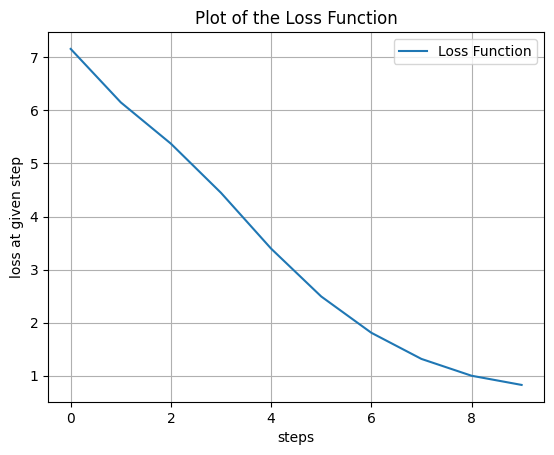

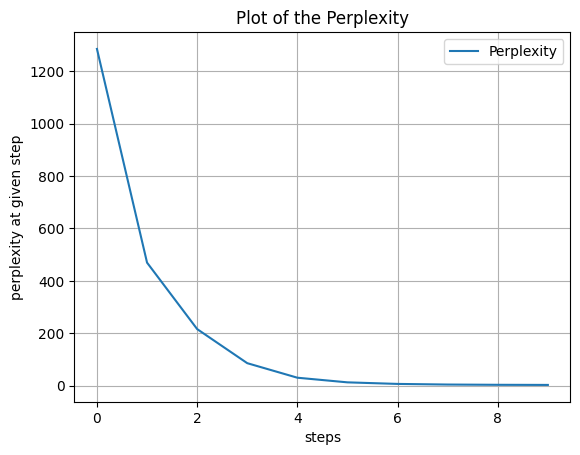


 Training model2 with TBTT ... 



Please enter a sentence:  Trump wants


user propmpt:  ['trump', 'wants']
Epoch: 1/6, Loss:   6.6146
Perplexity:  745.9046630859375
seed:  [100, 662]
argmax: 37
argmax: 1148
argmax: 23
argmax: 2584
argmax: 11301
argmax: 0
[100, 662] [SOFTMAX] => trump wants to cut a new plan to get away with a single <EOS>
argmax: 37
argmax: 1148
argmax: 23
argmax: 2584
argmax: 6567
argmax: 0
[100, 662] [ARGMAX] => trump wants to be a big problem <EOS>
Epoch: 2/6, Loss:   5.8402
Perplexity:  343.857421875
seed:  [100, 662]
argmax: 37
argmax: 3216
argmax: 893
argmax: 15
argmax: 8732
argmax: 0
[100, 662] [SOFTMAX] => trump wants to cut off food lobbyist to his own properties <EOS>
argmax: 37
argmax: 5869
argmax: 15
argmax: 8732
argmax: 0
[100, 662] [ARGMAX] => trump wants to gut the swamp <EOS>
Epoch: 3/6, Loss:   2.8009
Perplexity:  16.459653854370117
seed:  [100, 662]
argmax: 37
argmax: 1949
argmax: 0
[100, 662] [SOFTMAX] => trump wants to slap trump jr.'s meeting at obama urges but you missed the real politicians <EOS>
argmax: 37
argmax: 11

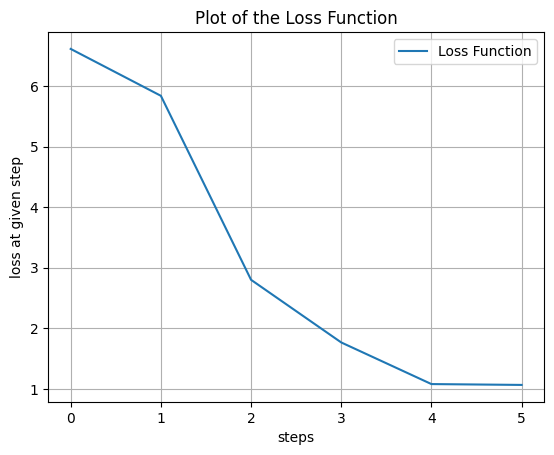

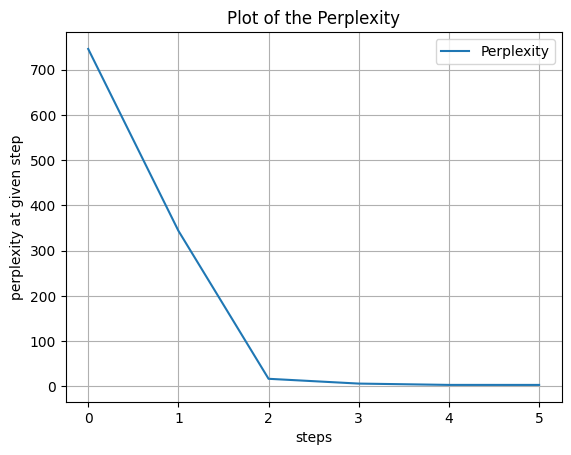

In [8]:
if __name__ == "__main__":
    if ((exists("/kaggle/working/", "word_to_int.pickle") == False) or (
            exists("/kaggle/working/", "int-to_word.pickle") == False) or (
            exists('/kaggle/working/', 'news_tokens.pickle') == False)):
        
        # ____________________DATA.1___________________________________________
        
        # Read JSON file into a Pandas DataFrame
        df = pd.read_json("/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json", lines=True)
        
        # Filter rows where the 'category' column is 'POLITICS'
        politics_df = df[df['category'] == 'POLITICS']
        politics_df.head(3).transpose().to_csv('/kaggle/working/transposed_data.csv', index=False)

        # ____________________DATA.2___________________________________________

        news_tokens = [headline.lower().split() + ['<EOS>'] for headline in politics_df['headline']]
        
        # Print the random headline and its tokenized version
        print('\n -------------Example of Headline and Tokenized Headline-----------------')
        print("Headline:", politics_df['headline'].iloc[115])
        print("Tokens:", news_tokens[115])
        print('------------------------------------------------------------------------')
        
        with open('/kaggle/working/news_tokens.pickle', 'wb') as handle:
            pickle.dump(news_tokens, handle, protocol=pickle.HIGHEST_PROTOCOL)

        # ____________________DATA.3___________________________________________
        all_words = ['<EOS>']
        word_recurrence = []

        print('Number of tokenized titles:' , len(news_tokens), "\n")
        for token in news_tokens:
            for word in token:  # [:-1]
                if word not in word_recurrence:
                    word_recurrence.append(word)
                if word not in all_words:
                    all_words.append(word)

        all_words.append("PAD")
        
        print('Number of unique words:' , len(all_words), "\n")
        
        word_to_int = {word: idx for idx, word in enumerate(all_words)} 
        int_to_word = {value: key for key, value in word_to_int.items()}
        
        
        print("word_to_int: ", len(word_to_int))
        print("int_to_wordt: ", len(int_to_word))
        print("all_words: ", len(all_words))

        with open('/kaggle/working/word_to_int.pickle', 'wb') as handle:
            pickle.dump(word_to_int, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open('/kaggle/working/int-to_word.pickle', 'wb') as handle:
            pickle.dump(int_to_word, handle, protocol=pickle.HIGHEST_PROTOCOL)

       

    else:
        print("=====Downloading Existing Data======")

        with open('/kaggle/working/news_tokens.pickle', 'rb') as handle:
            news_tokens = pickle.load(handle)
        with open('/kaggle/working/word_to_int.pickle', 'rb') as handle:
            word_to_int = pickle.load(handle)
        with open('/kaggle/working/int-to_word.pickle', 'rb') as handle:
            int_to_word = pickle.load(handle)

    # Count the occurrences of each word
    word_counts = Counter([word.lower() for sublist in news_tokens for word in sublist[:-1]])

    # Find the 5 most common words
    most_common_words = word_counts.most_common(5)

    print("5 Most Common Words:")
    for word, count in most_common_words:
        print(f"{word}: {count}")

    # ____________________DATA.4___________________________________________
    
    # DATASET CLASS
    dataset = CustomDataset(news_tokens, word_to_int)
    
    
    # ____________________DATA.5___________________________________________

    # COLLATE
    batch_size = 64  # 8
    if batch_size == 1:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    else:
        dataloader = DataLoader(dataset, batch_size=batch_size,
                                collate_fn=lambda b: collate_fn(b, word_to_int["PAD"]),
                                shuffle=True)   # by calling collate like this, the dataloader
                                                # will automatically pad the sequence for us
                                                # only in the batch, instead of padding all the
                                                # dataset w/ a fixed lenght
                                                
    # _________________________TRAINING.1____________________________________
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_epoch1 = 10
    num_epoch2 = 6
    # optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss(ignore_index=word_to_int["PAD"])
    
    #model1
    model1 = Model(word_to_int, 1024, 150, n_layers=2, dropout_p=0.15)
    
    #model2
    model2 = Model(word_to_int, 2048, 300, n_layers=1, dropout_p=0)
    
    #training model1
    model, loss_history, perplexity_history = train(model1, dataloader, num_epoch1, criterion, lr=1e-3,print_every=1,DEVICE=DEVICE)
    print("\n", "model1 ended training✅", "n" )
    plot_loss(loss_history,  np.arange(0,num_epoch1,1), True, label='Loss Function', title='Plot of the Loss Function')
    plot_loss(perplexity_history, np.arange(0,num_epoch1,1), True, label='Perplexity',title='Plot of the Perplexity', ylabel='perplexity at given step')
    
    #training model2 with TBTT
    model, loss_history, perplexity_history = train_with_TBBTT(num_epoch2, model2, dataloader, criterion,
                                                               optim.Adam(model2.parameters(), lr=0.001), 3, clip=1.0,
                                                               device=DEVICE, print_every=1)
    print("\n", "model2 ended training with TBTT✅", "\n" )
    plot_loss(loss_history, np.arange(0, num_epoch2, 1), True, label='Loss Function', title='Plot of the Loss Function')
    plot_loss(perplexity_history, np.arange(0, num_epoch2, 1), True, label='Perplexity', title='Plot of the Perplexity',
              ylabel='perplexity at given step')